# **Dimensionality reduction technics**

For a given model the prediction power usually increases as more features are added to the training sample then decreases when the dimentionality of the samples become too high. This phenomenon is called the curse of dimensionality. \\
To cope with datasets of high dimension some technics exist to reduce the dimensionality while droping as few information as possible. Here we are working on a dataset of relatively low dimension, 9 features or 13 with "ocean_proximity" feature one-hot encoded. So we expect the dimensionality reduction of the dataset to have little to no impact on the prediction power of the trained models. \\
The features can either be projected in a space of lower dimension or selected following a certain rule.

## **Imports and utils**

In [4]:
import math
import time
import itertools
import numpy
import pandas
import sklearn
from sklearn.utils import shuffle	
from sklearn.cross_validation import (train_test_split, ShuffleSplit, KFold)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (MinMaxScaler,LabelBinarizer)
from sklearn.decomposition import (FactorAnalysis, PCA, TruncatedSVD, FastICA)
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestRegressor
from pandas.tools.plotting import scatter_matrix
from scipy.stats import (spearmanr, pearsonr)
from scipy.linalg import svd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab import files


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
def handle_nan(dataset):
	return dataset.dropna()

def normalizer(dataset):
	scaler = MinMaxScaler() 
	scaled_values = scaler.fit_transform(dataset) 
	dataset_normalized = pandas.DataFrame(scaled_values)
	dataset_normalized.columns = dataset.columns
	return dataset_normalized

def one_hot_encoder(column):
	ocean_proximity_encoder = LabelBinarizer()
	encoded_class = ocean_proximity_encoder.fit_transform(column.values)
	encoded_class = pandas.DataFrame(data=encoded_class, columns=ocean_proximity_encoder.classes_)
	return encoded_class

def evaluate_model(model, X, Y):
	Y = Y.transpose().values
	predictions = rf.predict(X)
	errors = abs(predictions - Y)
	mae = numpy.mean(errors)
	mape = 100 * (errors / Y)
	accuracy = 100 - numpy.mean(mape)
	return mae, accuracy

In [49]:
uploaded = files.upload()
dataset = pandas.read_csv("housing.csv")

ocean_proximity = one_hot_encoder(dataset[["ocean_proximity"]])
dataset = dataset.drop('ocean_proximity', axis=1)
dataset[ocean_proximity.columns] = ocean_proximity

dataset = handle_nan(dataset)

dataset = shuffle(dataset)
Y = dataset[["median_house_value"]]
X = dataset.drop(['median_house_value'], axis=1)

print()

print("RandomForestRegressor")                 
rf = RandomForestRegressor()
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)

base_accuracy = accuracy_average


RandomForestRegressor
MAE : 32936.69233563033
Accuracy : 81.67285827927061 %
R^2 : 0.8078883272190113


## **Feature projection**

Because for each projection technics there is a severe drop in performance when training a random forest regressor, only representations of the projections are show here.

In [0]:
#apply factor analysis
#take normalizer function as argument
#return the transformed dataset
def factor_analysis_transform(dataset, normalizer, n_components=None, tolerance=0.01, max_iteration=1000):
	dataset_normalized = normalizer(dataset)
	transformer = FactorAnalysis(n_components=n_components, tol=tolerance, max_iter=max_iteration)
	factor = transformer.fit(dataset_normalized)
	df_factors = pandas.DataFrame(factor.components_,columns=dataset_normalized.columns)
	dataset_transformed = factor.transform(dataset_normalized)
	dataset_transformed = pandas.DataFrame(dataset_transformed)
	return dataset_transformed

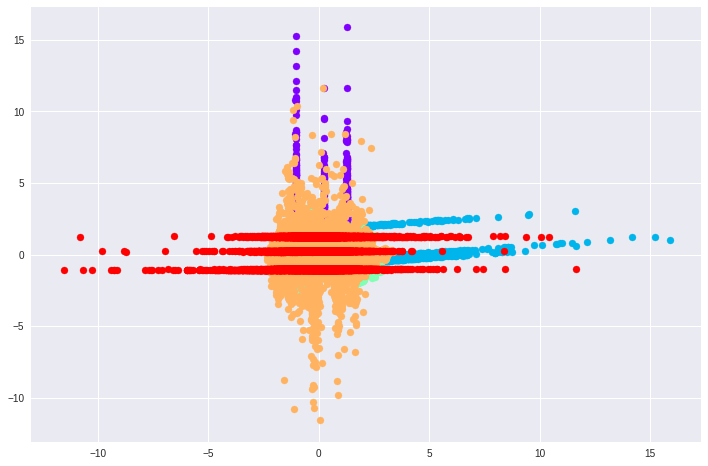

In [13]:
X_factor = factor_analysis_transform(X, normalizer, n_components=5, tolerance=1e-1, max_iteration=10000000)

colors = iter(cm.rainbow(numpy.linspace(0, 1, len(X_factor.columns))))
#X_factor_coordinate = [ 100*i for i in range(X_factor.shape[0]) ]

plt.figure(figsize=(12,8))
#for feature in X_factor.columns:
	#plt.scatter(X_factor_coordinate, X_factor[feature].values, color=next(colors))
plt.scatter(X_factor[X_factor.columns[0]].values, X_factor[X_factor.columns[1]].values, color=next(colors))
plt.scatter(X_factor[X_factor.columns[1]].values, X_factor[X_factor.columns[2]].values, color=next(colors))
plt.scatter(X_factor[X_factor.columns[2]].values, X_factor[X_factor.columns[3]].values, color=next(colors))
plt.scatter(X_factor[X_factor.columns[3]].values, X_factor[X_factor.columns[4]].values, color=next(colors))
plt.scatter(X_factor[X_factor.columns[4]].values, X_factor[X_factor.columns[0]].values, color=next(colors))
plt.show()

In [0]:
#apply singular value decomposition
#take normalizer function as argument
#return the transformed dataset
def SVD_transform(dataset, normalizer, n_components=2):
	dataset_normalized = normalizer(dataset)
	transformer = TruncatedSVD(n_components=n_components)
	factor = transformer.fit(dataset_normalized)
	df_factors = pandas.DataFrame(factor.components_,columns=dataset_normalized.columns)
	dataset_transformed = factor.transform(dataset_normalized)
	dataset_transformed = pandas.DataFrame(dataset_transformed)
	print (transformer.explained_variance_ratio_ )
	return dataset_transformed


[0.05032006 0.43883352 0.2123364  0.16309645 0.05971768]


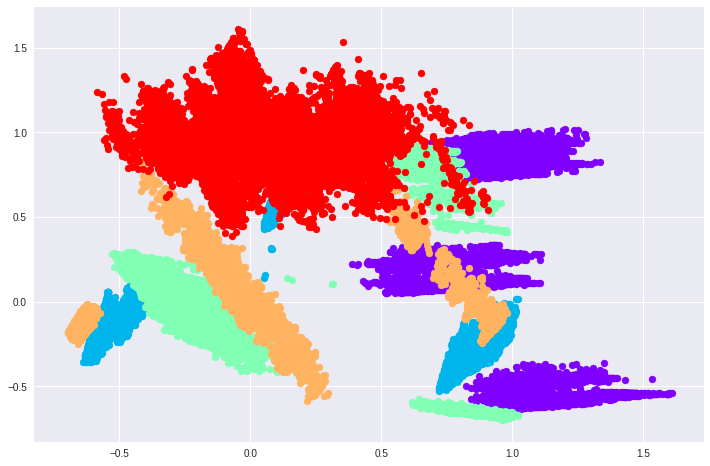

In [11]:
X_svd = SVD_transform(X, normalizer, n_components=5)

colors = iter(cm.rainbow(numpy.linspace(0, 1, len(X_svd.columns))))
X_svd_coordinate = [ 100*i for i in range(X_svd.shape[0]) ]

plt.figure(figsize=(12,8))
#for feature in X_svd.columns:
	#plt.scatter(X_svd_coordinate, X_svd[feature].values, color=next(colors))
plt.scatter(X_svd[X_svd.columns[0]].values, X_svd[X_svd.columns[1]].values, color=next(colors))
plt.scatter(X_svd[X_svd.columns[1]].values, X_svd[X_svd.columns[2]].values, color=next(colors))
plt.scatter(X_svd[X_svd.columns[2]].values, X_svd[X_svd.columns[3]].values, color=next(colors))
plt.scatter(X_svd[X_svd.columns[3]].values, X_svd[X_svd.columns[4]].values, color=next(colors))
plt.scatter(X_svd[X_svd.columns[4]].values, X_svd[X_svd.columns[0]].values, color=next(colors))
plt.show()

In [0]:
#apply principal component analysis
#take normalizer function as argument
#return the transformed dataset
def PCA_transform(dataset, normalizer, n_components=None):
	dataset_normalized = normalizer(dataset)
	transformer = PCA(n_components=n_components)
	factor = transformer.fit(dataset_normalized)
	df_factors = pandas.DataFrame(factor.components_,columns=dataset_normalized.columns)
	dataset_transformed = factor.transform(dataset_normalized)
	dataset_transformed = pandas.DataFrame(dataset_transformed)
	print (transformer.explained_variance_ratio_ )
	return dataset_transformed

[0.45806377 0.221678   0.1644691  0.06586991 0.05795901]


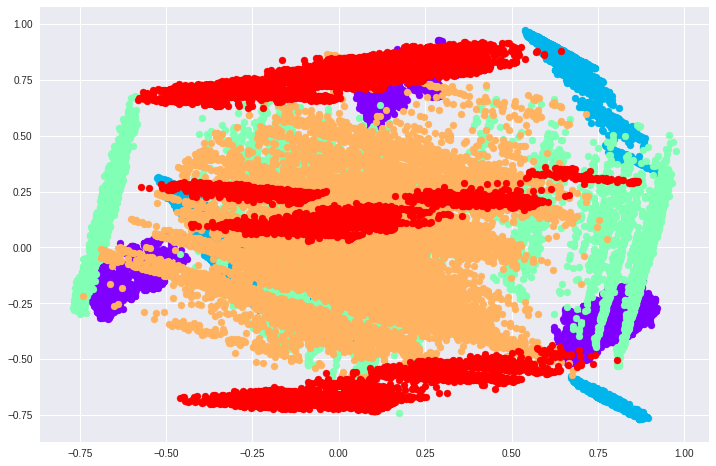

In [15]:
X_pca = PCA_transform(X, normalizer, n_components=5)

colors = iter(cm.rainbow(numpy.linspace(0, 1, len(X_pca.columns))))
X_pca_coordinate = [ 100*i for i in range(X_pca.shape[0]) ]

plt.figure(figsize=(12,8))
#for feature in X_pca.columns:
	#plt.scatter(X_pca_coordinate, X_pca[feature].values, color=next(colors))
plt.scatter(X_pca[X_pca.columns[0]].values, X_pca[X_pca.columns[1]].values, color=next(colors))
plt.scatter(X_pca[X_pca.columns[1]].values, X_pca[X_pca.columns[2]].values, color=next(colors))
plt.scatter(X_pca[X_pca.columns[2]].values, X_pca[X_pca.columns[3]].values, color=next(colors))
plt.scatter(X_pca[X_pca.columns[3]].values, X_pca[X_pca.columns[4]].values, color=next(colors))
plt.scatter(X_pca[X_pca.columns[4]].values, X_pca[X_pca.columns[0]].values, color=next(colors))
plt.show()

In [0]:
#apply independant component analysis
#take normalizer function as argument
#return the transformed dataset
def ICA_transform(dataset, normalizer, n_components=None, tolerance=0.0001, max_iteration=200):
	dataset_normalized = normalizer(dataset)
	transformer = FastICA(n_components=n_components, tol=tolerance, max_iter=max_iteration)
	factor = transformer.fit(dataset_normalized)
	df_factors = pandas.DataFrame(factor.components_,columns=dataset_normalized.columns)
	dataset_transformed = factor.transform(dataset_normalized)
	dataset_transformed = pandas.DataFrame(dataset_transformed)
	return dataset_transformed

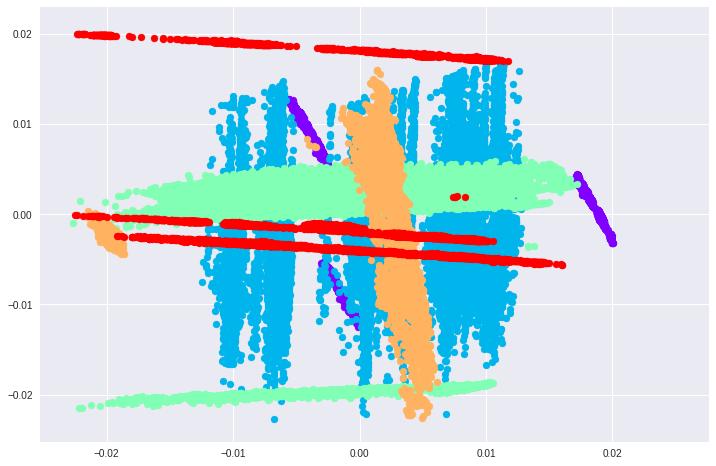

In [18]:
X_ica = ICA_transform(X, normalizer, n_components=5, tolerance=1e-14, max_iteration=200000)

colors = iter(cm.rainbow(numpy.linspace(0, 1, len(X_ica.columns))))
X_ica_coordinate = [ 100*i for i in range(X_ica.shape[0]) ]

plt.figure(figsize=(12,8))
#for feature in X_ica.columns:
	#plt.scatter(X_ica_coordinate, X_ica[feature].values, color=next(colors))
plt.scatter(X_ica[X_ica.columns[0]].values, X_ica[X_ica.columns[1]].values, color=next(colors))
plt.scatter(X_ica[X_ica.columns[1]].values, X_ica[X_ica.columns[2]].values, color=next(colors))
plt.scatter(X_ica[X_ica.columns[2]].values, X_ica[X_ica.columns[3]].values, color=next(colors))
plt.scatter(X_ica[X_ica.columns[3]].values, X_ica[X_ica.columns[4]].values, color=next(colors))
plt.scatter(X_ica[X_ica.columns[4]].values, X_ica[X_ica.columns[0]].values, color=next(colors))
plt.show()

In [0]:
#apply isomap
#take normalizer function as argument
#return the transformed dataset
def ISOMAP_transform(dataset, normalizer, n_components=2, n_neighbors=5):
	dataset_normalized = normalizer(dataset)
	transformer = Isomap(n_components=n_components, n_neighbors=n_neighbors)
	factor = transformer.fit(dataset_normalized)
	df_factors = pandas.DataFrame(factor.components_,columns=dataset_normalized.columns)
	dataset_transformed = factor.transform(dataset_normalized)
	dataset_transformed = pandas.DataFrame(dataset_transformed)
	return dataset_transformed

In [0]:
X_isomap = ISOMAP_transform(X, normalizer, n_components=5)

colors = iter(cm.rainbow(numpy.linspace(0, 1, len(X_isomap.columns))))
X_isomap_coordinate = [ 100*i for i in range(X_isomap.shape[0]) ]

plt.figure(figsize=(12,8))
for feature in X_isomap.columns:
	plt.scatter(X_isomap_coordinate, X_isomap[feature].values, color=next(colors))
plt.show()

## **Feature selection**

In [0]:
#whithdraw any feature having a variance below the threshold
#take normalizer function as argument
#return the dataset
def low_variance_filter(dataset, normalizer, threshold=0):
	dataset_normalized = normalizer(dataset)
	print ("Low variance filter")
	thresholder = VarianceThreshold(threshold)
	thresholder.fit(dataset_normalized)
	dataset_high_variance = dataset.loc[:,dataset.columns[thresholder.get_support(indices=True)]]
	print ("variances : ")
	print (thresholder.variances_)
	print ("caught by the filter ( threshold =",threshold,"): "),
	print ([x for x in dataset.columns if x not in dataset_high_variance.columns])
	return dataset_high_variance

In [55]:
X_high_variance = low_variance_filter(X, normalizer, threshold=0.01)
print()

print("RandomForestRegressor")                 
rf = RandomForestRegressor()
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X_high_variance.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X_high_variance.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)
print("accuracy - base_accuracy :", accuracy_average-base_accuracy, "%")

Low variance filter
variances : 
[3.98220653e-02 5.15398748e-02 6.09557088e-02 3.08891490e-03
 4.27588454e-03 1.00872559e-03 3.95216962e-03 1.71559153e-02
 2.46650824e-01 2.16845816e-01 2.44642318e-04 9.87527436e-02
 1.12073535e-01]
caught by the filter ( threshold = 0.01 ): 
['total_rooms', 'total_bedrooms', 'population', 'households', 'ISLAND']

RandomForestRegressor
MAE : 32404.194450009723
Accuracy : 82.19050533202932 %
R^2 : 0.8080214034091601
accuracy - base_accuracy : 0.5176470527587043 %


In [0]:
#whitdraw any feature with correlation value with another feature above the threshold
#return the dataset
def high_correlation_filter(dataset, threshold=1):
  print ("High correlation filter ( threshold =", threshold,")")
  dataset_low_correlation = pandas.DataFrame()
  pearson_matrix = []
  spearman_matrix = []

  for i,entry_1 in enumerate(dataset.columns):
    pearson_matrix.append([])
    spearman_matrix.append([])
    for j,entry_2 in enumerate(dataset.columns):
      pearson_matrix[i].append(pearsonr(dataset[entry_1], dataset[entry_2])[0])
      spearman_matrix[i].append(spearmanr(dataset[entry_1], dataset[entry_2])[0])

  for i in range(len(dataset.columns)):
    dropped = False
    for j in range(i):
      if(abs(pearson_matrix[i][j]) > threshold or abs(spearman_matrix[i][j]) > threshold):
        print (dataset.columns[i]+" correlated with "+dataset.columns[j])
        print("dropped column :", dataset.columns[i])
        dropped = True
    if(not dropped):
      dataset_low_correlation[dataset.columns[i]] = dataset[dataset.columns[i]]

  return dataset_low_correlation

In [64]:
X_low_correlation = high_correlation_filter(X, threshold=0.93)
print()

print("RandomForestRegressor")                 
rf = RandomForestRegressor()
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X_low_correlation.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X_low_correlation.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)
print("accuracy - base_accuracy :", accuracy_average-base_accuracy, "%")

High correlation filter ( threshold = 0.93 )
total_bedrooms correlated with total_rooms
dropped column : total_bedrooms
households correlated with total_bedrooms
dropped column : households

RandomForestRegressor
MAE : 32759.137793563623
Accuracy : 81.85873893337669 %
R^2 : 0.8082684218941093
accuracy - base_accuracy : 0.18588065410607157 %


In [0]:
#build a training dataset, adding one feature at a time, stop when performance decrease
#performance is evaluate with kfold X-validation and an evaluation function (k and the function are passed in arguments)
#return a list of feature's name
def forward_feature_selection(model, X, Y, evaluation_function, kfold=3):
  print ("Forward feature selection")
  kf = KFold(X.shape[0], n_folds=kfold)
  available_features = list(X.columns.values)
  selected_features = []
  best_accuracy = 0
  prediction_improved = True
  while(prediction_improved is True and len(available_features)!=0):
    prediction_improved = False
    for feature in available_features:
      accuracy = 0
      selected_features.append(feature)
      for train_idx, test_idx in kf:
        X_train = X.iloc[train_idx,:]
        X_train = X_train[selected_features]
        Y_train = Y.iloc[train_idx]
        X_test = X.iloc[test_idx,:]
        X_test = X_test[selected_features]
        Y_test = Y.iloc[test_idx]
        model.fit(X_train, Y_train.values.ravel())
        mae, fold_accuracy = evaluation_function(model, X_test, Y_test)
        accuracy += fold_accuracy
      accuracy = accuracy / kfold
      if(accuracy > best_accuracy):
        prediction_improved = True
        best_accuracy = accuracy
        best_feature = feature
        print ("best_accuracy ", best_accuracy)
        print ("best_feature", best_feature)
      selected_features.remove(feature)
    if(prediction_improved is True):
      selected_features.append(best_feature)
      available_features.remove(best_feature)

  return selected_features

In [73]:
rf = RandomForestRegressor()

selected_features = forward_feature_selection(rf, X, Y, evaluate_model, kfold=10)
X_forward_selection = X[selected_features]
print()

print("RandomForestRegressor")
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X_forward_selection.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X_forward_selection.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)
print("accuracy - base_accuracy :", accuracy_average-base_accuracy, "%")

Forward feature selection
best_accuracy  55.90330728301525
best_feature longitude
best_accuracy  56.63141274104653
best_feature median_income
best_accuracy  68.80069461676712
best_feature longitude
best_accuracy  82.55109461965502
best_feature latitude
best_accuracy  82.55426716173997
best_feature INLAND
best_accuracy  82.61809060087487
best_feature NEAR BAY
best_accuracy  82.62101453338047
best_feature NEAR OCEAN
best_accuracy  82.63152314539002
best_feature NEAR BAY

RandomForestRegressor
MAE : 31661.524259147503
Accuracy : 82.64394254895072 %
R^2 : 0.8166298581624
accuracy - base_accuracy : 0.9710842696801052 %


In [0]:
#build a training dataset, removing one feature at a time, stop when performance decrease
#performance is evaluate with kfold X-validation and an evaluation function (k and the function are passed in arguments)
#return a list of feature's name
def backward_feature_selection(model, X, Y, evaluation_function, kfold=3):
  print ("Backward feature selection")
  kf = KFold(X.shape[0], n_folds=kfold)
  # available_features = list(X.columns.values)
  kept_features = list(X.columns.values)
  best_accuracy = 0
  prediction_improved = True
  while(prediction_improved is True and len(kept_features)!=0):
    prediction_improved = False
    for feature in kept_features:
      accuracy = 0
      kept_features.remove(feature)
      for train_idx, test_idx in kf:
        X_train = X.iloc[train_idx,:]
        X_train = X_train[kept_features]
        Y_train = Y.iloc[train_idx]
        X_test = X.iloc[test_idx,:]
        X_test = X_test[kept_features]
        Y_test = Y.iloc[test_idx]
        model.fit(X_train, Y_train.values.ravel())
        mae, fold_accuracy = evaluation_function(model, X_test, Y_test)
        accuracy += fold_accuracy
      accuracy = accuracy / kfold
      if(accuracy > best_accuracy):
        prediction_improved = True
        best_accuracy = accuracy
        worst_feature = feature
        print ("best_accuracy ", best_accuracy)
        print ("worst_feature", worst_feature)
      kept_features.append(feature)
    if(prediction_improved is True):
      kept_features.remove(worst_feature)

  return kept_features

In [77]:
rf = RandomForestRegressor()

selected_features = backward_feature_selection(rf, X, Y, evaluate_model, kfold=10)
X_backward_selection = X[selected_features]
print()

print("RandomForestRegressor")
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X_backward_selection.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X_backward_selection.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)
print("accuracy - base_accuracy :", accuracy_average-base_accuracy, "%")

Backward feature selection
best_accuracy  77.78156890080422
worst_feature longitude
best_accuracy  81.89749659037713
worst_feature housing_median_age
best_accuracy  81.99343102491197
worst_feature INLAND
best_accuracy  82.03645095365894
worst_feature <1H OCEAN

RandomForestRegressor
MAE : 32503.19565773971
Accuracy : 81.88879546739703 %
R^2 : 0.8114491560737359
accuracy - base_accuracy : 0.21593718812641782 %


In [0]:
#build a training dataset, removing one feature at a time, stop when performance decrease
#performance is evaluate with kfold X-validation and an evaluation function (k and the function are passed in arguments)
#here the feature importances list of the model is used to remove a feature
#return a list of feature's name
def backward_feature_selection2(model, X, Y, evaluation_function, kfold=3):
  print ("Backward feature selection using feature importances of model")
  kf = KFold(X.shape[0], n_folds=kfold)
  kept_features = list(X.columns.values)
  best_accuracy = 0
  prediction_improved = True
  while(prediction_improved is True and len(kept_features)!=0):
    prediction_improved = False
    accuracy = 0
    for train_idx, test_idx in kf:
      X_train = X.iloc[train_idx,:]
      X_train = X_train[kept_features]
      Y_train = Y.iloc[train_idx]
      X_test = X.iloc[test_idx,:]
      X_test = X_test[kept_features]
      Y_test = Y.iloc[test_idx]
      model.fit(X_train, Y_train.values.ravel())
      mae, fold_accuracy = evaluation_function(model, X_test, Y_test)
      accuracy += fold_accuracy
    accuracy = accuracy / kfold
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(kept_features, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    print (feature_importances)
    if(accuracy > best_accuracy):
      prediction_improved = True
      best_accuracy = accuracy
      worst_feature = feature_importances[-1][0]
      print ("best_accuracy ", best_accuracy)
      print ("worst_feature", worst_feature)
      kept_features.remove(worst_feature)


  return kept_features

In [88]:
rf = RandomForestRegressor()

selected_features = backward_feature_selection2(rf, X, Y, evaluate_model, kfold=10)
X_backward_selection2 = X[selected_features]
print()

print("RandomForestRegressor")
n_folds = 10
kf = KFold(X.shape[0], n_folds=n_folds)
mae_average = 0
accuracy_average = 0
r2_average = 0

for train_idx, test_idx in kf:
  X_train = X_backward_selection2.iloc[train_idx,:]
  Y_train = Y.iloc[train_idx]
  X_test = X_backward_selection2.iloc[test_idx,:]
  Y_test = Y.iloc[test_idx]

  rf.fit(X_train, Y_train.values.ravel())
  mae,accuracy = evaluate_model(rf, X_test, Y_test)
  mae_average += mae/n_folds
  accuracy_average += accuracy/n_folds
  r2_average += rf.score(X_test, Y_test)/n_folds
print("MAE :", mae_average)
print("Accuracy :", accuracy_average, "%")
print("R^2 :", r2_average)
print("accuracy - base_accuracy :", accuracy_average-base_accuracy, "%")

Backward feature selection using feature importances of model
[('median_income', 0.49), ('INLAND', 0.14), ('longitude', 0.11), ('latitude', 0.1), ('housing_median_age', 0.05), ('population', 0.03), ('total_rooms', 0.02), ('total_bedrooms', 0.02), ('households', 0.02), ('NEAR OCEAN', 0.01), ('<1H OCEAN', 0.0), ('ISLAND', 0.0), ('NEAR BAY', 0.0)]
best_accuracy  81.77521423627442
worst_feature NEAR BAY
[('median_income', 0.48), ('INLAND', 0.14), ('longitude', 0.11), ('latitude', 0.1), ('housing_median_age', 0.05), ('total_rooms', 0.03), ('population', 0.03), ('total_bedrooms', 0.02), ('households', 0.02), ('NEAR OCEAN', 0.01), ('<1H OCEAN', 0.0), ('ISLAND', 0.0)]

RandomForestRegressor
MAE : 33073.707127796886
Accuracy : 81.64583699666474 %
R^2 : 0.804796711633178
accuracy - base_accuracy : -0.027021282605872443 %


# **Conclusion**

In this case with the housing dataset and a random forest regressor, the feature projection technics don't improve the prediction power of the model. In the other hand, feature selection technics and in particular forward and backward selections turn out to improve the model up to 1% better.